### Import Modules

In [ ]:
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit, float64
import time

### Open and Interpolate Real World Data

In [ ]:
# Specify the file path of the Excel file
file_path = "step_response_700_with_random.xlsx"

# Load the Excel file
original_df = pd.read_excel(file_path)

duration = 15  # duration in seconds
dt = 0.0001  # time increment

# Create a time array
time_array = np.arange(0, duration + dt, dt)

new_trolley_position = np.interp(
    time_array, original_df["timestamp"], original_df["trolley_position"]
)
new_cable_length = np.interp(
    time_array, original_df["timestamp"], original_df["cable_length"]
)
new_sway_angle = np.interp(
    time_array, original_df["timestamp"], original_df["sway_angle"]
)
new_trolley_motor_voltage = np.interp(
    time_array, original_df["timestamp"], original_df["trolley_motor_voltage"]
)
new_hoist_motor_voltage = np.interp(
    time_array, original_df["timestamp"], original_df["hoist_motor_voltage"]
)

interpolated_df = pd.DataFrame(
    {
        "time": time_array,
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_motor_voltage": new_trolley_motor_voltage,
        "hoist_motor_voltage": new_hoist_motor_voltage,
    }
)

dataframe_header = list(interpolated_df.columns)
print(dataframe_header)
print(
    f"New data length: {len(time_array)}, {len(new_trolley_position)}, {len(new_cable_length)}, {len(new_sway_angle)}, {len(new_trolley_motor_voltage)}, {len(new_hoist_motor_voltage)}"
)

interpolated_array = [interpolated_df[column].values for column in interpolated_df.columns]

# for i in range (1, len(dataframe_header)):
#     plt.plot(interpolated_array[0], interpolated_array[i], label=dataframe_header[i])
#     plt.legend()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Value")
#     plt.show()

# interpolated_df.to_excel("interpolated_data.xlsx", index=False)

### Open and Set Model Parameters

In [ ]:
# Open the JSON file
with open("gantry_crane_parameters.json", "r") as file:
    data = json.load(file)

all_parameters = data["gantry_crane_system_model"]["parameters"]
measured_parameters = {}
approximated_parameters = {}

for parameter in all_parameters:
    value = all_parameters[parameter]["value"]
    unit = all_parameters[parameter]["unit"]
    description = all_parameters[parameter]["description"]

    if all_parameters[parameter]["measured"]:
        measured_parameters[parameter] = all_parameters[parameter]
    else:
        approximated_parameters[parameter] = all_parameters[parameter]

    # print(f"{parameter}: {value} {unit} ({description})")

#### Optimized Model Simulation Core Function

In [ ]:
# Define the function with JIT compilation
@jit(nopython=True)
def simulate_core(
    num_steps,
    dt,
    L_tm,
    L_hm,
    rp_tm,
    rp_hm,
    m_t,
    m_c,
    J_tm,
    J_hm,
    Kt_tm,
    Kt_hm,
    Kemf_tm,
    Kemf_hm,
    R_tm,
    R_hm,
    b_t,
    b_c,
    b_tm,
    b_hm,
    g,
    inputs,
    initial_conditions,
):
    x = np.zeros(num_steps + 1)
    l = np.zeros(num_steps + 1)
    theta = np.zeros(num_steps + 1)
    x_dot = np.zeros(num_steps + 1)
    l_dot = np.zeros(num_steps + 1)
    theta_dot = np.zeros(num_steps + 1)
    x_dot_dot = np.zeros(num_steps + 1)
    l_dot_dot = np.zeros(num_steps + 1)
    theta_dot_dot = np.zeros(num_steps + 1)
    # Ux = np.zeros(num_steps + 1)
    # Ul = np.zeros(num_steps + 1)

    if inputs is not None:
        # trolley_motor_voltage = inputs[0]
        # hoist_motor_voltage = inputs[1]
        Ux = inputs[0]
        Ul = inputs[1]

    if initial_conditions is not None:
        x[0] = initial_conditions[0]
        l[0] = initial_conditions[1]
        theta[0] = initial_conditions[2]

    for i in range(num_steps):
        # print(i)
        # Update matrix A
        a_1_1 = L_tm * rp_tm * (
            m_t + m_c * np.sin(theta[i]) ** 2
        ) / Kt_tm + J_tm * L_tm / (Kt_tm * rp_tm)

        a_1_2 = -L_tm * m_c * rp_tm * np.sin(theta[i]) / Kt_tm

        a_2_1 = -L_hm * m_c * rp_hm * np.sin(theta[i]) / Kt_hm
        a_2_2 = L_hm * m_c * rp_hm / Kt_hm + J_hm * L_hm / (Kt_hm * rp_hm)

        # Update matrix B
        b_1_1 = (
            +L_tm * m_c * rp_tm * np.sin(2 * theta[i]) * theta_dot[i] / Kt_tm
            + R_tm * rp_tm * (m_t + m_c * np.sin(theta[i]) ** 2) / Kt_tm
            + L_tm * b_t * rp_tm / Kt_tm
            + J_tm * R_tm / (Kt_tm * rp_tm)
            + L_tm * b_tm / (Kt_tm * rp_tm)
        )

        b_1_2 = (
            -L_tm * m_c * rp_tm * np.cos(theta[i]) * theta_dot[i] / Kt_tm
            - R_tm * m_c * rp_tm * np.sin(theta[i]) / Kt_tm
        )

        b_2_1 = (
            -L_hm * m_c * rp_hm * np.cos(theta[i]) * theta_dot[i] / Kt_hm
            - R_hm * m_c * rp_hm * np.sin(theta[i]) / Kt_hm
        )

        b_2_2 = (
            +L_hm * b_c * rp_hm / Kt_hm
            + R_hm * m_c * rp_hm / Kt_hm
            + J_hm * R_hm / (Kt_hm * rp_hm)
            + L_hm * b_hm / (Kt_hm * rp_hm)
        )

        # Update matrix C
        c_1_1 = (
            R_tm * b_t * rp_tm / Kt_tm + Kemf_tm / rp_tm + R_tm * b_tm / (Kt_tm * rp_tm)
        )

        c_2_2 = (
            R_hm * b_c * rp_hm / Kt_hm + Kemf_hm / rp_hm + R_hm * b_hm / (Kt_hm * rp_hm)
        )

        # Update matrix D
        d_1 = 2 * L_tm * m_c * rp_tm * l[i] * np.sin(theta[i]) * theta_dot[i] / Kt_tm
        d_2 = -2 * L_hm * m_c * rp_hm * l[i] * theta_dot[i] / Kt_hm

        # Update matrix E
        e_1 = (
            L_tm * m_c * rp_tm * l[i] * np.cos(theta[i]) * theta_dot[i] ** 2 / Kt_tm
            + L_tm * g * m_c * rp_tm * np.cos(2 * theta[i]) / Kt_tm
            + L_tm * m_c * rp_tm * np.sin(theta[i]) * l_dot[i] * theta_dot[i] / Kt_tm
            + R_tm * m_c * rp_tm * l[i] * np.sin(theta[i]) * theta_dot[i] / Kt_tm
        )

        e_2 = (
            +L_hm * g * m_c * rp_hm * np.sin(theta[i]) / Kt_hm
            - L_hm * m_c * rp_hm * l_dot[i] * theta_dot[i] / Kt_hm
            - R_hm * m_c * rp_hm * l[i] * theta_dot[i] / Kt_hm
        )

        # Update matrix F
        f_1 = R_tm * g * m_c * rp_tm * np.sin(theta[i]) * np.cos(theta[i]) / Kt_tm

        f_2 = -R_hm * g * m_c * rp_hm * np.cos(theta[i]) / Kt_hm

        # Ux[i] = trolley_motor_voltage[i]
        # Ul[i] = hoist_motor_voltage[i]

        temp_x_triple_dot = (
            Ux[i]
            - b_1_1 * x_dot_dot[i]
            - b_1_2 * l_dot_dot[i]
            - c_1_1 * x_dot[i]
            - d_1 * theta_dot_dot[i]
            - e_1 * theta_dot[i]
            - f_1
        )
        temp_l_triple_dot = (
            Ul[i]
            - b_2_1 * x_dot_dot[i]
            - b_2_2 * l_dot_dot[i]
            - c_2_2 * l_dot[i]
            - d_2 * theta_dot_dot[i]
            - e_2 * theta_dot[i]
            - f_2
        )

        determinant = (a_1_1 * a_2_2 - a_1_2 * a_2_1)

        x_triple_dot = (a_2_2 * temp_x_triple_dot - a_1_2 * temp_l_triple_dot) * 1 / determinant
        l_triple_dot = (a_1_1 * temp_l_triple_dot - a_2_1 * temp_x_triple_dot) * 1 / determinant

        # if control_now[0, 0] < bias_tm:
        #     q_triple_dot_now[0, 0] = 0

        # if control_now[1, 0] < bias_hm:
        #     q_triple_dot_now[1, 0] = 0

        x_dot_dot[i + 1] = x_dot_dot[i] + x_triple_dot * dt

        l_dot_dot[i + 1] = l_dot_dot[i] + l_triple_dot * dt

        theta_dot_dot_temp_ = (
            np.cos(theta[i]) * x_dot_dot[i]
            - 2 * l_dot[i] * theta_dot[i]
            - np.sin(theta[i]) * g
        ) / l[i]
        theta_dot_dot[i + 1] = theta_dot_dot_temp_

        x_dot[i + 1] = x_dot[i] + x_dot_dot[i + 1] * dt

        l_dot[i + 1] = l_dot[i] + l_dot_dot[i + 1] * dt

        theta_dot[i + 1] = theta_dot[i] + theta_dot_dot[i + 1] * dt

        x[i + 1] = x[i] + x_dot[i + 1] * dt

        l[i + 1] = l[i] + l_dot[i + 1] * dt

        theta[i + 1] = theta[i] + theta_dot[i + 1] * dt

        # Ux[i + 1] = trolley_motor_voltage[i + 1]

        # Ul[i + 1] = hoist_motor_voltage[i + 1]

    return (
        x,
        l,
        theta,
        x_dot,
        l_dot,
        theta_dot,
        x_dot_dot,
        l_dot_dot,
        theta_dot_dot,
        Ux,
        Ul,
    )

### Simulator Class to do Simulation and Get Results

In [ ]:
class Simulator:
    def __init__(self):
        self.simulation_successful = False

    def set_parameters(self, parameters):
        self.m_c = 1e-3
        self.g = 1e-3
        self.L_tm = 1e-3
        self.L_hm = 1e-3
        self.R_tm = 1e-3
        self.R_hm = 1e-3
        self.rp_tm = 1e-3
        self.rp_hm = 1e-3
        self.m_t = 1e-3
        self.b_t = 1e-3
        self.b_c = 1e-3
        self.b_tm = 1e-3
        self.b_hm = 1e-3
        self.J_tm = 1e-3
        self.J_hm = 1e-3
        self.Kemf_tm = 1e-3
        self.Kemf_hm = 1e-3
        self.Kt_tm = 1e-3
        self.Kt_hm = 1e-3
        # self.bias_tm = 1e-3
        # self.bias_hm = 1e-3


        if parameters is not None:
            for parameter in parameters:
                # Measured parameters
                if parameter == "container_mass":
                    self.m_c = parameters["container_mass"]["value"]

                if parameter == "gravity_acceleration":
                    self.g = parameters["gravity_acceleration"]["value"]

                if parameter == "trolley_motor_inductance":
                    self.L_tm = parameters["trolley_motor_inductance"]["value"]

                if parameter == "trolley_motor_resistance":
                    self.R_tm = parameters["trolley_motor_resistance"]["value"]

                if parameter == "trolley_motor_pulley_radius":
                    self.rp_tm = parameters["trolley_motor_pulley_radius"]["value"]

                if parameter == "hoist_motor_inductance":
                    self.L_hm = parameters["hoist_motor_inductance"]["value"]

                if parameter == "hoist_motor_resistance":
                    self.R_hm = parameters["hoist_motor_resistance"]["value"]

                if parameter == "hoist_motor_pulley_radius":
                    self.rp_hm = parameters["hoist_motor_pulley_radius"]["value"]

                # Not measured parameters
                if parameter == "trolley_mass":
                    self.m_t = parameters["trolley_mass"]["value"]

                if parameter == "trolley_damping_coefficient":
                    self.b_t = parameters["trolley_damping_coefficient"]["value"]

                if parameter == "cable_damping_coefficient":
                    self.b_c = parameters["cable_damping_coefficient"]["value"]

                if parameter == "trolley_motor_rotator_inertia":
                    self.J_tm = parameters["trolley_motor_rotator_inertia"]["value"]

                if parameter == "trolley_motor_damping_coefficient":
                    self.b_tm = parameters["trolley_motor_damping_coefficient"]["value"]

                if parameter == "trolley_motor_back_emf_constant":
                    self.Kemf_tm = parameters["trolley_motor_back_emf_constant"]["value"]

                if parameter == "trolley_motor_torque_constant":
                    self.Kt_tm = parameters["trolley_motor_torque_constant"]["value"]

                if parameter == "hoist_motor_rotator_inertia":
                    self.J_hm = parameters["hoist_motor_rotator_inertia"]["value"]

                if parameter == "hoist_motor_damping_coefficient":
                    self.b_hm = parameters["hoist_motor_damping_coefficient"]["value"]

                if parameter == "hoist_motor_back_emf_constant":
                    self.Kemf_hm = parameters["hoist_motor_back_emf_constant"]["value"]

                if parameter == "hoist_motor_torque_constant":
                    self.Kt_hm = parameters["hoist_motor_torque_constant"]["value"]

                # if parameter == 'trolley_motor_bias':
                #     self.bias_tm = parameters["trolley_motor_bias"]["value"]

                # if parameter == 'hoist_motor_bias':
                #     self.bias_hm = parameters["hoist_motor_bias"]["value"]

        else:
            raise ValueError("Parameters are not provided")

    def set_variables(self, num_steps, initial_conditions):
        # Initial conditions
        self.x = np.zeros(num_steps)
        self.x_dot = np.zeros(num_steps)
        self.x_dot_dot = np.zeros(num_steps)
        self.l = np.zeros(num_steps)
        self.l_dot = np.zeros(num_steps)
        self.l_dot_dot = np.zeros(num_steps)
        self.theta = np.zeros(num_steps)
        self.theta_dot = np.zeros(num_steps)
        self.theta_dot_dot = np.zeros(num_steps)
        self.Ux = np.zeros(num_steps)
        self.Ul = np.zeros(num_steps)

        if initial_conditions is not None:
            for variable in initial_conditions:
                if variable == "x":
                    self.x = [initial_conditions[variable]]
                if variable == "l":
                    self.l = [initial_conditions[variable]]
                if variable == "theta":
                    self.theta = [initial_conditions[variable]]
        else:
            print("Initial conditions are not provided")
            print("Setting initial conditions to default values...")
            self.l[0] = 1.0  # Cable length can never be zero

    def simulate(self, num_steps, dt, parameters, inputs, initial_conditions):
        self.dt = dt
        self.num_steps = num_steps
        self.set_variables(num_steps, initial_conditions)
        self.set_parameters(parameters)

        if inputs is not None:
            for input in inputs:
                if input == "trolley_motor_voltage":
                    self.Ux = inputs[input]
                if input == "hoist_motor_voltage":
                    self.Ul = inputs[input]

        input_voltages = [self.Ux, self.Ul]

        variable_initial_conditions = [self.x[0], self.l[0], self.theta[0]]

        self.simulation_successful = True
        try:
            (
                self.x,
                self.l,
                self.theta,
                self.x_dot,
                self.l_dot,
                self.theta_dot,
                self.x_dot_dot,
                self.l_dot_dot,
                self.theta_dot_dot,
                self.Ux,
                self.Ul,
            ) = simulate_core(
                self.num_steps - 1,
                self.dt,
                self.L_tm,
                self.L_hm,
                self.rp_tm,
                self.rp_hm,
                self.m_t,
                self.m_c,
                self.J_tm,
                self.J_hm,
                self.Kt_tm,
                self.Kt_hm,
                self.Kemf_tm,
                self.Kemf_hm,
                self.R_tm,
                self.R_hm,
                self.b_t,
                self.b_c,
                self.b_tm,
                self.b_hm,
                self.g,
                input_voltages, 
                variable_initial_conditions,
            )

        except Exception as e:
            print(f"An error occurred: {e}")
            self.simulation_successful = False

    def simulate_legacy(self, num_steps, dt, parameters, inputs, initial_conditions):
        self.dt = dt
        self.num_steps = num_steps
        self.set_variables(num_steps, initial_conditions)
        self.set_parameters(parameters)

        if inputs is not None:
            for input in inputs:
                if input == "trolley_motor_voltage":
                    self.Ux = inputs[input]
                if input == "hoist_motor_voltage":
                    self.Ul = inputs[input]

        self.matrix_A = np.matrix([[0.0, 0.0], [0.0, 0.0]])
        self.matrix_B = np.matrix([[0.0, 0.0], [0.0, 0.0]])
        self.matrix_C = np.matrix([[0.0, 0.0], [0.0, 0.0]])
        self.matrix_D = np.matrix([[0.0], [0.0]])
        self.matrix_E = np.matrix([[0.0], [0.0]])
        self.matrix_F = np.matrix([[0.0], [0.0]])

        self.simulation_successful = True
        for i in tqdm(range(self.num_steps - 1)):
            # print(f"Iteration: {i}", end="\r", flush=True)
            try:
                with warnings.catch_warnings(record=True) as caught_warnings:
                    warnings.simplefilter("error", RuntimeWarning)

                    # Update matrix A
                    self.matrix_A[0, 0] = self.L_tm * self.rp_tm * (
                        self.m_t + self.m_c * np.sin(self.theta[i]) ** 2
                    ) / self.Kt_tm + self.J_tm * self.L_tm / (self.Kt_tm * self.rp_tm)
                    self.matrix_A[0, 1] = (
                        -self.L_tm
                        * self.m_c
                        * self.rp_tm
                        * np.sin(self.theta[i])
                        / self.Kt_tm
                    )
                    self.matrix_A[1, 0] = (
                        -self.L_hm
                        * self.m_c
                        * self.rp_hm
                        * np.sin(self.theta[i])
                        / self.Kt_hm
                    )
                    self.matrix_A[1, 1] = (
                        self.L_hm * self.m_c * self.rp_hm / self.Kt_hm
                        + self.J_hm * self.L_hm / (self.Kt_hm * self.rp_hm)
                    )

                    # Update matrix B
                    self.matrix_B[0, 0] = (
                        +self.L_tm
                        * self.m_c
                        * self.rp_tm
                        * np.sin(2 * self.theta[i])
                        * self.theta_dot[i]
                        / self.Kt_tm
                        + self.R_tm
                        * self.rp_tm
                        * (self.m_t + self.m_c * np.sin(self.theta[i]) ** 2)
                        / self.Kt_tm
                        + self.L_tm * self.b_t * self.rp_tm / self.Kt_tm
                        + self.J_tm * self.R_tm / (self.Kt_tm * self.rp_tm)
                        + self.L_tm * self.b_tm / (self.Kt_tm * self.rp_tm)
                    )
                    self.matrix_B[0, 1] = (
                        -self.L_tm
                        * self.m_c
                        * self.rp_tm
                        * np.cos(self.theta[i])
                        * self.theta_dot[i]
                        / self.Kt_tm
                        - self.R_tm
                        * self.m_c
                        * self.rp_tm
                        * np.sin(self.theta[i])
                        / self.Kt_tm
                    )
                    self.matrix_B[1, 0] = (
                        -self.L_hm
                        * self.m_c
                        * self.rp_hm
                        * np.cos(self.theta[i])
                        * self.theta_dot[i]
                        / self.Kt_hm
                        - self.R_hm
                        * self.m_c
                        * self.rp_hm
                        * np.sin(self.theta[i])
                        / self.Kt_hm
                    )
                    self.matrix_B[1, 1] = (
                        +self.L_hm * self.b_c * self.rp_hm / self.Kt_hm
                        + self.R_hm * self.m_c * self.rp_hm / self.Kt_hm
                        + self.J_hm * self.R_hm / (self.Kt_hm * self.rp_hm)
                        + self.L_hm * self.b_hm / (self.Kt_hm * self.rp_hm)
                    )

                    # Update matrix C
                    self.matrix_C[0, 0] = (
                        self.R_tm * self.b_t * self.rp_tm / self.Kt_tm
                        + self.Kemf_tm / self.rp_tm
                        + self.R_tm * self.b_tm / (self.Kt_tm * self.rp_tm)
                    )
                    self.matrix_C[1, 1] = (
                        self.R_hm * self.b_c * self.rp_hm / self.Kt_hm
                        + self.Kemf_hm / self.rp_hm
                        + self.R_hm * self.b_hm / (self.Kt_hm * self.rp_hm)
                    )

                    # Update matrix D
                    self.matrix_D[0, 0] = (
                        2
                        * self.L_tm
                        * self.m_c
                        * self.rp_tm
                        * self.l[i]
                        * np.sin(self.theta[i])
                        * self.theta_dot[i]
                        / self.Kt_tm
                    )
                    self.matrix_D[1, 0] = (
                        -2
                        * self.L_hm
                        * self.m_c
                        * self.rp_hm
                        * self.l[i]
                        * self.theta_dot[i]
                        / self.Kt_hm
                    )

                    # Update matrix E
                    self.matrix_E[0, 0] = (
                        self.L_tm
                        * self.m_c
                        * self.rp_tm
                        * self.l[i]
                        * np.cos(self.theta[i])
                        * self.theta_dot[i] ** 2
                        / self.Kt_tm
                        + self.L_tm
                        * self.g
                        * self.m_c
                        * self.rp_tm
                        * np.cos(2 * self.theta[i])
                        / self.Kt_tm
                        + self.L_tm
                        * self.m_c
                        * self.rp_tm
                        * np.sin(self.theta[i])
                        * self.l_dot[i]
                        * self.theta_dot[i]
                        / self.Kt_tm
                        + self.R_tm
                        * self.m_c
                        * self.rp_tm
                        * self.l[i]
                        * np.sin(self.theta[i])
                        * self.theta_dot[i]
                        / self.Kt_tm
                    )
                    self.matrix_E[1, 0] = (
                        +self.L_hm
                        * self.g
                        * self.m_c
                        * self.rp_hm
                        * np.sin(self.theta[i])
                        / self.Kt_hm
                        - self.L_hm
                        * self.m_c
                        * self.rp_hm
                        * self.l_dot[i]
                        * self.theta_dot[i]
                        / self.Kt_hm
                        - self.R_hm
                        * self.m_c
                        * self.rp_hm
                        * self.l[i]
                        * self.theta_dot[i]
                        / self.Kt_hm
                    )

                    # Update matrix F
                    self.matrix_F[0, 0] = (
                        self.R_tm
                        * self.g
                        * self.m_c
                        * self.rp_tm
                        * np.sin(self.theta[i])
                        * np.cos(self.theta[i])
                        / self.Kt_tm
                    )
                    self.matrix_F[1, 0] = (
                        -self.R_hm
                        * self.g
                        * self.m_c
                        * self.rp_hm
                        * np.cos(self.theta[i])
                        / self.Kt_hm
                    )

                    # Create variable for q, q_dot, q_dot_dot, and q_desired
                    q_now = np.matrix([[self.x[i]], [self.l[i]]])
                    q_dot_now = np.matrix([[self.x_dot[i]], [self.l_dot[i]]])
                    q_dot_dot_now = np.matrix(
                        [[self.x_dot_dot[i]], [self.l_dot_dot[i]]]
                    )

                    # Create variable for control input
                    control_now = np.matrix(
                        [[self.Ux[i]], [self.Ul[i]]]
                    )

                    # Update self.x_dot_dot, self.l_dot_dot, self.theta_dot_dot using state space equations
                    q_triple_dot_now = np.matmul(
                        np.linalg.inv(self.matrix_A),
                        (
                            control_now
                            - (
                                self.matrix_B * q_dot_dot_now
                                + self.matrix_C * q_dot_now
                                + self.matrix_D * self.theta_dot_dot[i]
                                + self.matrix_E * self.theta_dot[i]
                                + self.matrix_F
                            )
                        ),
                    )

                    # if control_now[0, 0] < self.bias_tm:
                    #     q_triple_dot_now[0, 0] = 0

                    # if control_now[1, 0] < self.bias_hm:
                    #     q_triple_dot_now[1, 0] = 0

                    self.x_dot_dot[i + 1] = (
                        self.x_dot_dot[i] + q_triple_dot_now[0, 0] * dt
                    )

                    self.l_dot_dot[i + 1] = (
                        self.l_dot_dot[i] + q_triple_dot_now[1, 0] * dt
                    )

                    theta_dot_dot_temp_ = (
                        np.cos(self.theta[i]) * self.x_dot_dot[i]
                        - 2 * self.l_dot[i] * self.theta_dot[i]
                        - np.sin(self.theta[i]) * self.g
                    ) / self.l[i]
                    self.theta_dot_dot[i + 1] = theta_dot_dot_temp_

                    self.x_dot[i + 1] = self.x_dot[i] + self.x_dot_dot[i + 1] * dt

                    self.l_dot[i + 1] = self.l_dot[i] + self.l_dot_dot[i + 1] * dt

                    self.theta_dot[i + 1] = (
                        self.theta_dot[i] + self.theta_dot_dot[i + 1] * dt
                    )

                    self.x[i + 1] = self.x[i] + self.x_dot[i + 1] * dt

                    self.l[i + 1] = self.l[i] + self.l_dot[i + 1] * dt

                    self.theta[i + 1] = self.theta[i] + self.theta_dot[i + 1] * dt

                    if self.check_divergence():
                        print("Divergence detected at step", i)
                        self.simulation_successful = False
                        break

            except RuntimeWarning as e:
                print(f"Caught a runtime warning at step {i}: {e}")
                self.simulation_successful = False
                break
            except Exception as e:
                print(f"An error occurred at step {i}: {e}")
                self.simulation_successful = False
                break

    def create_dataframe(self):
        if self.simulation_successful:
            print("Creating dataframe...")
            print(
                f"Data length: {self.num_steps}, {len(self.x)}, {len(self.x_dot)}, {len(self.x_dot_dot)}, {len(self.l)}, {len(self.l_dot)}, {len(self.l_dot_dot)}, {len(self.theta)}, {len(self.theta_dot)}, {len(self.theta_dot_dot)}, {len(self.Ux)}, {len(self.Ul)}"
            )
            data = {
                "time": np.arange(0, self.num_steps * self.dt, self.dt),
                "trolley_position": self.x,
                "trolley_position_first_derivative": self.x_dot,
                "trolley_position_second_derivative": self.x_dot_dot,
                "cable_length": self.l,
                "cable_length_first_derivative": self.l_dot,
                "cable_length_second_derivative": self.l_dot_dot,
                "sway_angle": self.theta,
                "sway_angle_first_derivative": self.theta_dot,
                "sway_angle_second_derivative": self.theta_dot_dot,
                "trolley_motor_voltage": self.Ux,
                "hoist_motor_voltage": self.Ul,
            }
            return pd.DataFrame(data)
        else:
            return None

    def get_results_for_optimization(self):
        if self.simulation_successful:
            return [
                np.arange(0, self.num_steps * self.dt, self.dt),
                self.x,
                self.l,
                self.theta,
                self.Ux,
                self.Ul,
            ]
        else:
            return []

    def check_divergence(self):
        if (
            np.isnan(self.x).any()
            or np.isnan(self.x_dot).any()
            or np.isnan(self.x_dot_dot).any()
            or np.isnan(self.l).any()
            or np.isnan(self.l_dot).any()
            or np.isnan(self.l_dot_dot).any()
            or np.isnan(self.theta).any()
            or np.isnan(self.theta_dot).any()
            or np.isnan(self.theta_dot_dot).any()
        ):
            return True
        else:
            return False

##### Optimized Function to Calculate Squared Error

In [ ]:
@jit(nopython=True)
def calculate_squared_errors(y1, y2):
    squared_errors = np.zeros(len(y1))
    for i in range(len(y1)):
        squared_errors[i] = (y1[i] - y2[i]) ** 2
    return squared_errors

##### Optimized Function to Calculate Sum Root Mean Squared Error (RMSE)

In [ ]:
@jit(nopython=True)
def calculate_sum_root_mean_squared_errors(dataframe_header_, interpolated_array_, simulated_array_):
    sum_root_mean_squared_errors = 0.0
    for i in range (1, len(dataframe_header_)):
        y1 = interpolated_array_[i]
        y2 = simulated_array_[i]
        root_mean_squared_errors = np.sqrt(sum(calculate_squared_errors(y1, y2))/len(y1))
        sum_root_mean_squared_errors += root_mean_squared_errors
    return sum_root_mean_squared_errors

### Define Searching Range to Optimize Model Parameters

In [ ]:
optimize_range = {
    "trolley_mass": (1.0, 5.0), # Done
    "trolley_damping_coefficient": (0.1, 10.0), # Done
    "cable_damping_coefficient": (0.1, 10.0), # Done
    "trolley_motor_rotator_inertia": (0.00001, 0.001), # Done
    "trolley_motor_damping_coefficient": (0.1, 10.0),
    "trolley_motor_back_emf_constant": (0.001, 0.1), # Done
    "trolley_motor_torque_constant": (0.01, 1.0), # Done
    "hoist_motor_rotator_inertia": (0.000001, 0.0001), # Done
    "hoist_motor_damping_coefficient": (0.1, 10.0),
    "hoist_motor_back_emf_constant": (0.01, 1.0), # Done
    "hoist_motor_torque_constant": (0.0001, 0.01),  # Done
}

### Declare Simulator Object

In [ ]:
simulator = Simulator()

## Simulated Annealing

## Gradient Descent

### Define learning rate for each parameter

In [ ]:
parameters_learning_rate = {}

for parameter in optimize_range:
    parameters_learning_rate[parameter] = min(optimize_range[parameter]) / 10

print("Learning rate:", parameters_learning_rate)

# Create random value for each parameter within the specified range
random_parameters = {}
for parameter in optimize_range:
    random_parameters[parameter] = np.random.uniform(
        optimize_range[parameter][0], optimize_range[parameter][1]
    )

print("Initial value:", random_parameters)

In [ ]:
optimized_parameters = all_parameters

for parameter in random_parameters:
    optimized_parameters[parameter]["value"] = random_parameters[parameter]

old_parameter = optimized_parameters

#### Optimize Model Parameters with Gradient Descent Algoritm

In [17]:
num_steps = len(interpolated_array[0])
input_voltages = {'trolley_motor_voltage': interpolated_array[4], 'hoist_motor_voltage': interpolated_array[5]}
variables_initial_conditions = {'x': interpolated_array[1][0], 'l': interpolated_array[2][0], 'theta': interpolated_array[3][0]}
epoch = 0
count = 0
epochs = []
total_sum_root_mean_squared_errors_array = []
while epoch <= 2000:
    steps = 0
    total_sum_root_mean_squared_errors = 0
    for parameter in optimize_range:
        simulator.simulate(num_steps, dt, optimized_parameters, input_voltages, variables_initial_conditions)
        simulated_array = simulator.get_results_for_optimization()

        sum_root_mean_squared_errors = calculate_sum_root_mean_squared_errors(
            dataframe_header, interpolated_array, simulated_array
        )

        # Calculate the cost function derivative relative to parameter value
        h = 1e-6
        optimized_parameters[parameter]["value"] += h
        simulator.simulate(num_steps, dt, optimized_parameters, input_voltages, variables_initial_conditions)
        simulated_array_h = simulator.get_results_for_optimization()

        sum_root_mean_squared_errors_h = calculate_sum_root_mean_squared_errors(
            dataframe_header, interpolated_array, simulated_array_h
        )

        derivative = (sum_root_mean_squared_errors_h - sum_root_mean_squared_errors) / h

        # print(derivative)

        steps = parameters_learning_rate[parameter] * derivative
        optimized_parameters[parameter]["steps"] = steps
        optimized_parameters[parameter]["value"] -= steps

        # print(end="\r")
        # print(
        #     "Parameter:",
        #     parameter,
        #     "| Value:",
        #     optimized_parameters[parameter]["value"],
        #     "| Loss:",
        #     sum_root_mean_squared_errors,
        #     "Step size:",
        #     steps,
        #     end="\r",
        # )

        total_sum_root_mean_squared_errors += sum_root_mean_squared_errors

    count = 0
    for parameter in optimize_range:
        if abs(optimized_parameters[parameter]["steps"]) < 1e-6:
            count += 1

    print(
            "Epoch:",
            epoch,
            "\t| Total loss:",
            round(total_sum_root_mean_squared_errors, 6),
            "\t| Converge count:",
            count,
            end="\r",
        )
    
    if count == len(optimized_parameters):
        break

    epochs.append(epoch)
    total_sum_root_mean_squared_errors_array.append(total_sum_root_mean_squared_errors)

    epoch += 1

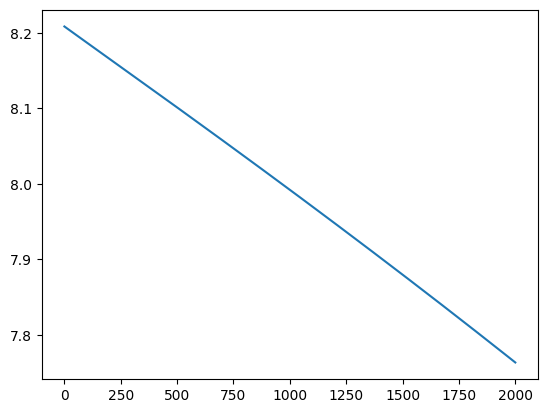

In [18]:
plt.plot(epochs, total_sum_root_mean_squared_errors_array)
plt.show()

In [19]:
json_string = json.dumps(optimized_parameters, indent=4)

# Step 3: Write the JSON string to a file
with open("optimized_parameter.json", "w") as json_file:
    json_file.write(json_string)

for parameter in optimized_parameters:
    # print(parameter)
    if (
        old_parameter[parameter]["value"]
        != optimized_parameters[parameter]["value"]
    ):
        print("Old", parameter, "value:", old_parameter[parameter]["value"])
        print("Old", parameter, "value:", optimized_parameters[parameter]["value"])

### Simulate Optimized Parameters and Compare to Real Data

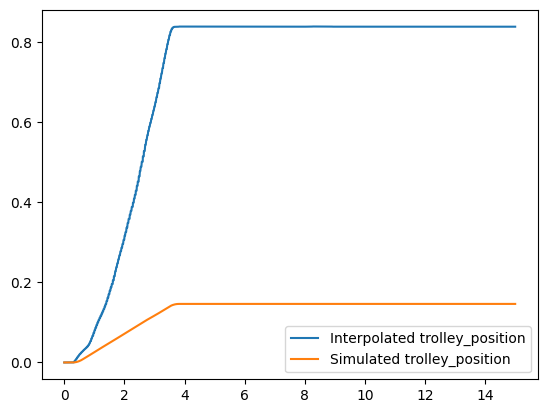

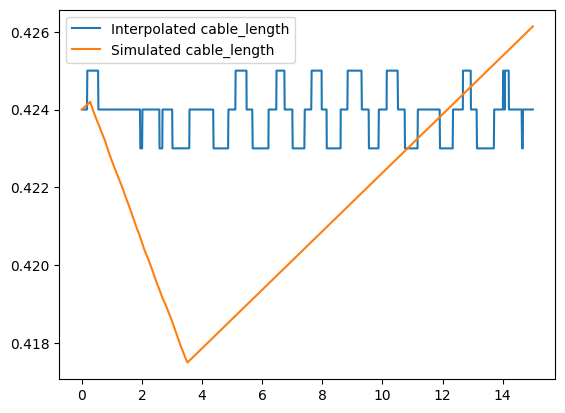

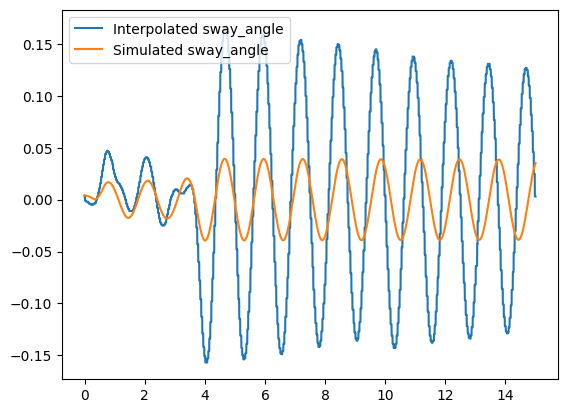

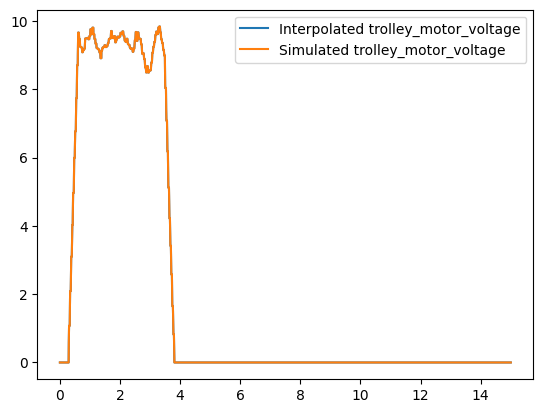

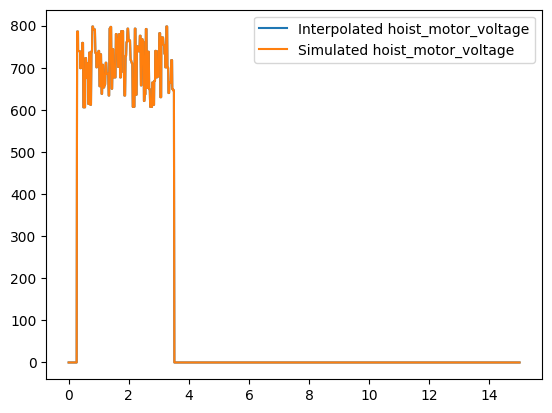

In [20]:
num_steps = len(interpolated_array[0])
input_voltages = {
    "trolley_motor_voltage": interpolated_array[4],
    "hoist_motor_voltage": interpolated_array[5],
}
variables_initial_conditions = {
    "x": interpolated_array[1][0],
    "l": interpolated_array[2][0],
    "theta": interpolated_array[3][0],
}
simulator.simulate(
    num_steps, dt, all_parameters, input_voltages, variables_initial_conditions
)

simulated_array = simulator.get_results_for_optimization()
for i in range(1, len(dataframe_header)):
    y1 = np.array(interpolated_array[i])
    y2 = np.array(simulated_array[i])

    plt.plot(time_array, y1, label=f"Interpolated {dataframe_header[i]}")
    plt.plot(time_array, y2, label=f"Simulated {dataframe_header[i]}")
    plt.legend()
    plt.show()